In [210]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from data.generator import PVDataGenerator
from data.lfm_dataset import PV_LFM_Dataset
from data.utils import *
from alfi.utilities.data import flatten_dataset
from models.lfm import ExactLFM
from plotting import plot_train_test_split

In [228]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 25
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 3
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 4
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
NUM_OUTPUTS = 4


==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



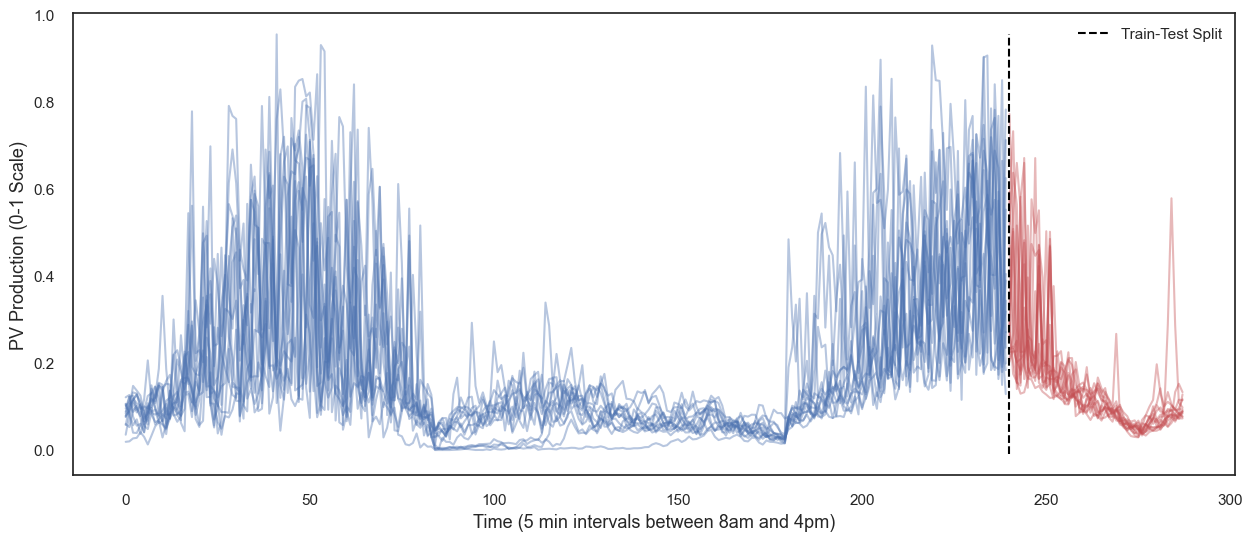

In [229]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = generator.get_time_series()
x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED, minute_interval=MINUTE_INTERVAL)
plot_train_test_split(y_train, y_test)


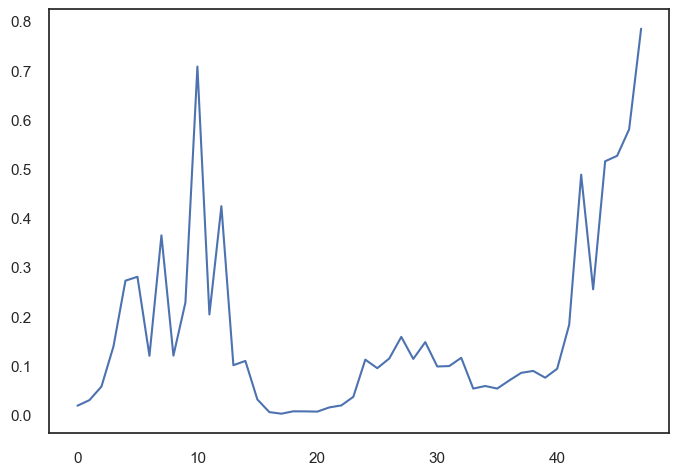

In [251]:
interval = 5

x_obs = x_train[::interval] 
# add noise to observations
y_obs = y_train[::interval, 0] 

plt.plot(y_obs)

# Exact Latent Force Model

In [252]:
N_OBS = 1
m_observed = y_obs.unsqueeze(-1)
f_observed = x_obs[:,1]

t_obs = torch.linspace(0, 1, len(x_obs))
t_train = torch.linspace(0+1/1e2, 1 - 1/1e2 , len(x_train)) 
t_test = torch.linspace(1, (len(x_test) + len(x_train))/len(x_train), len(x_test))

In [253]:
# create dataset
dataset = PV_LFM_Dataset(N_OBS, m_observed, f_observed, t_obs, 1*torch.ones(N_OBS) )
train_t, train_y = flatten_dataset(dataset)

train_t = train_t.view(-1, 1)
train_y = train_y.view(-1, 1)

In [254]:
model = ExactLFM(dataset, dataset.variance.reshape(-1))                                                      
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model) 

In [255]:
from lfm_trainer import ExactTrainer

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
# trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)

model.likelihood.train()
a = trainer.train(epochs=500, report_interval=50)


Epoch 001/500 - Loss: 0.84 λ: [0.08]
Epoch 051/500 - Loss: -0.41 λ: [0.08]
Epoch 101/500 - Loss: -0.63 λ: [0.08]
Epoch 151/500 - Loss: -0.63 λ: [0.08]
Epoch 201/500 - Loss: -0.63 λ: [0.08]
Epoch 251/500 - Loss: -0.63 λ: [0.08]
Epoch 301/500 - Loss: -0.63 λ: [0.08]
Epoch 351/500 - Loss: -0.63 λ: [0.08]
Epoch 401/500 - Loss: -0.63 λ: [0.08]
Epoch 451/500 - Loss: -0.63 λ: [0.08]


In [256]:
t_predict_train = torch.linspace(t_train.min(), t_train.max(), len(t_train))
t_predict_test = torch.linspace(t_test.min(), t_test.max(), len(t_test))
jitter = 1e-3
p_m_train = model.predict_m(t_predict_train, jitter=jitter)
p_f_train = model.predict_f(t_predict_train, jitter=jitter)

p_m_test = model.predict_m(t_predict_test, jitter=jitter)
p_f_test = model.predict_f(t_predict_test, jitter=jitter)

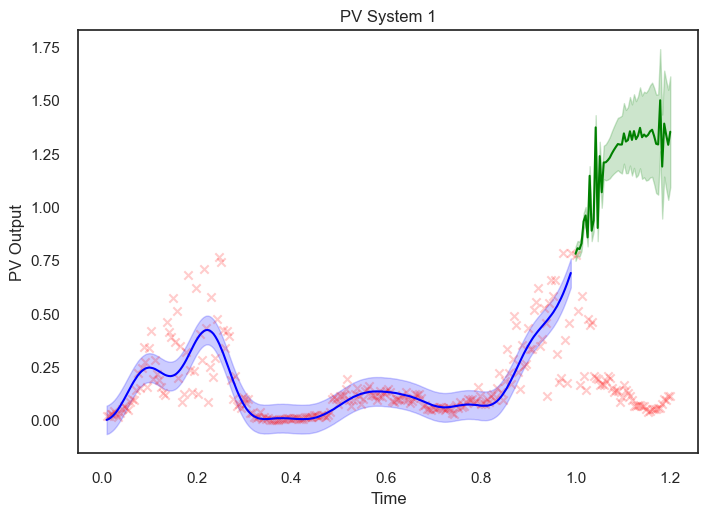

In [257]:
pv_mean_train = p_m_train.mean.detach().numpy().transpose(0, 1)
pv_std_train = p_m_train.variance.detach().sqrt().numpy().transpose(0, 1)

pv_mean_test = p_m_test.mean.detach().numpy().transpose(0, 1)
pv_std_test = p_m_test.variance.detach().sqrt().numpy().transpose(0, 1)

# remove the extra dimension from f
lf_mean_train = p_f_train.mean.detach().numpy().transpose(0, 1).squeeze()
lf_std_train = p_f_train.variance.detach().sqrt().numpy().transpose(0, 1).squeeze()

lf_mean_test = p_f_test.mean.detach().numpy().transpose(0, 1).squeeze()
lf_std_test = p_f_test.variance.detach().sqrt().numpy().transpose(0, 1).squeeze()


num_plots = pv_mean_train.shape[1]


fig, axs = plt.subplots(num_plots, 1)
if num_plots == 1:
    pv_mean_train = pv_mean_train.squeeze()
    pv_std_train = pv_std_train.squeeze()
    pv_mean_test = pv_mean_test.squeeze()
    pv_std_test = pv_std_test.squeeze()

    axs.plot(t_predict_train, pv_mean_train, color='blue')
    axs.fill_between(t_predict_train, pv_mean_train - 2*pv_std_train, pv_mean_train + 2*pv_std_train, color='blue', alpha=0.2)
    axs.plot(t_predict_test, pv_mean_test, color='green')
    axs.fill_between(t_predict_test, pv_mean_test - pv_std_test, pv_mean_test + pv_std_test, color='green', alpha=0.2)
    axs.scatter(t_train, y_train[:,0], color='red', alpha=0.2, marker='x')
    axs.scatter(t_test, y_test[:,0], color='red', alpha=0.2, marker='x')
    
    axs.set_title('PV System 1')
    axs.set_xlabel('Time')
    axs.set_ylabel('PV Output')
